In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn.functional import softplus

#DATA IMPORTING LIBRARIES
# Add the src folder to the path
import sys
sys.path.insert(0, '../src/')

from data.dataloader import MidiDataset
from data.bar_transform import BarTransform
from torch.utils.data import Dataset, DataLoader

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split


#half of this is not yet needed but maybe it will be to visualize the latent space
import matplotlib.pyplot as plt
from IPython.display import Image, Audio, display, clear_output
import numpy as np
from sklearn.decomposition import PCA
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))

from midi_builder import MidiBuilder
builder = MidiBuilder()


cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


NOTESPERBAR=16 #total notes in one bar

totalbars=16 #total bars as input 
NUM_PITCHES=60 # all possible notes to play


TOTAL_NOTES=NOTESPERBAR*totalbars

num_features=NUM_PITCHES #size of input feature vector

batch_size = 32 #actual batchsize

TEACHER_FORCING=True #not used but it will be needed


LOADING DATA

In [2]:
transform = BarTransform(bars=totalbars, note_count=NUM_PITCHES)#configures number of input bars

midi_dataset = MidiDataset(csv_file='./concat.csv', transform = transform) #imports dataset

midi_dataset.get_mem_usage()


random_seed = 42


test_split = .2
shuffle = True

if random_seed is not None:
    np.random.seed(random_seed)
    
    
dataset_size = len(midi_dataset)           #number of musics on dataset
test_size = int(test_split * dataset_size) #test size length
train_size = dataset_size - test_size      #train data length

train_dataset, test_dataset = random_split(midi_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=4)#, sampler=train_sampler)
test_loader = DataLoader(test_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=4)#, sampler=test_sampler)

print("Train size: {}, Test size: {}".format(train_size, test_size))


D:\Users\Ramiro\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Train size: 20848, Test size: 5211


MODEL:

In [23]:


# define size variables
input_size = NUM_PITCHES

enc_hidden_size=512 #hidden size of encoder
conductor_hidden_size=60 #hidden size of decoder

decoders_hidden_size=256 #hidden size of decoder
decoders_initial_size=32 #decoder input size

n_layers_conductor=2 #not being used rn cuz number of layers is incorrect
n_layers_decoder=3 #not being used rn cuz number of layers is incorrect

latent_features=20 #latent space dimension

sequence_length = 16 #notes per decoder



class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_features,teacher_forcing):
        super(VariationalAutoencoder, self).__init__()
        
        
        self.teacher_forcing = teacher_forcing
        self.latent_features = latent_features
               
        #data goes into bidirectional encoder
        self.encoder = torch.nn.LSTM(
                batch_first = True,
                input_size = input_size,
                hidden_size = enc_hidden_size,
                num_layers = 1,
                bidirectional = True)
        
        self.conductor = torch.nn.LSTM(input_size=latent_features, hidden_size=conductor_hidden_size, num_layers=1, batch_first=True)

        
        self.hidden2mean = nn.Linear(enc_hidden_size * 2, latent_features)
        self.hidden2logv = nn.Linear(enc_hidden_size * 2, latent_features)

        
    #used to initialize the hidden layer of the encoder to zero before every batch
    def init_hidden(self, batch_size):
        #must be 2 x batch x hidden_size because its a bi-directional LSTM
        init = torch.zeros(2, batch_size, enc_hidden_size, device=device)
        c0 = torch.zeros(2, batch_size, enc_hidden_size, device=device)
    
        #2 because has 2 layers
        #n_layers_conductor
        init_conductor = torch.zeros(1, batch_size, conductor_hidden_size, device=device)
        c_condunctor = torch.zeros(1, batch_size, conductor_hidden_size, device=device)
    
        #2 because has 2 layers
        #n_layers_decoder
        #init_decoders = torch.zeros(1, batch_size, decoders_hidden_size, device=device)
        #c_decoders= torch.zeros(1, batch_size, decoders_hidden_size, device=device)
        
        
        
        
        return init,c0,init_conductor,c_condunctor


    def forward(self, x):
        
        
        batch_size = x.size(0)
        
    
        outputs = {}
                
        #creates hidden layer values
        h0,c0,hconductor,cconductor = self.init_hidden(batch_size)
           
        #print("in",x.shape)
        
        #resets encoder at the beginning of every batch and gives it x
        x, hidden = self.encoder(x, ( h0,c0))
        
        mu = self.hidden2mean(x)
        log_var = self.hidden2logv(x)

        
        # where epsilon ~ N(0, 1)
                
        # Don't propagate gradients through randomness
        with torch.no_grad():
            batch_size = mu.size(0)
            epsilon = torch.randn(batch_size, 1, latent_features)
            
            if cuda:
                epsilon = epsilon.cuda()
        
        #setting sigma
        sigma = torch.exp(log_var * 0.5)
              
        #generate z - latent space
        z = mu + epsilon * sigma
        
        #print("z",z.shape)

        conductor_hidden = (hconductor,cconductor)
        
        embedding, conductor_hidden = self.conductor(z, conductor_hidden)    
        
        
        outputs["x_hat"] = torch.softmax(embedding, dim=2);
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        
        return outputs

net = VariationalAutoencoder(latent_features,TEACHER_FORCING)

# Transfer model to GPU if available
if cuda:
    net = net.cuda()

print(net)

VariationalAutoencoder(
  (encoder): LSTM(60, 512, batch_first=True, bidirectional=True)
  (conductor): LSTM(20, 60, batch_first=True)
  (hidden2mean): Linear(in_features=1024, out_features=20, bias=True)
  (hidden2logv): Linear(in_features=1024, out_features=20, bias=True)
)


Optimizer

In [24]:
#directly taken from notebook, probably some adaptation might be needed

from torch.nn.functional import binary_cross_entropy
from torch import optim
from torch.distributions.normal import Normal
from torch.distributions.kl import kl_divergence


def ELBO_loss(y, t, mu, log_var, weight):
    # Reconstruction error, log[p(x|z)]
    # Sum over features
    likelihood = -binary_cross_entropy(y, t, reduction="none")
    likelihood = likelihood.view(likelihood.size(0), -1).sum(1)

    # Regularization error: 
    # Kulback-Leibler divergence between approximate posterior, q(z|x)
    # and prior p(z) = N(z | mu, sigma*I).
    sigma = torch.exp(log_var*2)
    n_mu = torch.Tensor([0])
    n_sigma = torch.Tensor([1])
    if cuda:
        n_mu = n_mu.cuda()
        n_sigma = n_sigma.cuda()

    p = Normal(n_mu, n_sigma)
    q = Normal(mu, sigma)

    #The method signature is P and Q, but might need to be reversed to calculate divergence of Q with respect to P
    kl_div = kl_divergence(q, p)
    
    # In the case of the KL-divergence between diagonal covariance Gaussian and 
    # a standard Gaussian, an analytic solution exists. Using this excerts a lower
    # variance estimator of KL(q||p)
    #kl = -weight * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=(1,2))
    
    # Combining the two terms in the evidence lower bound objective (ELBO) 
    # mean over batch
    ELBO = torch.mean(likelihood)# - (weight*torch.mean(kl_div)) # add a weight to the kl using warmup
    
    # notice minus sign as we want to maximise ELBO
    return -ELBO, kl_div.mean() # mean instead of sum



# define our optimizer
# The Adam optimizer works really well with VAEs.
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = ELBO_loss

Testing if forward pass works

In [25]:
from torch.autograd import Variable

#setting dummy data
#Generating dummy data
a= np.random.randint(NUM_PITCHES, size=TOTAL_NOTES)
data = np.zeros((TOTAL_NOTES, NUM_PITCHES))
data[np.arange(TOTAL_NOTES), a] = 1 #generating dummy data

a= np.random.randint(NUM_PITCHES, size=TOTAL_NOTES)
data1 = np.zeros((TOTAL_NOTES, NUM_PITCHES))
data1[np.arange(TOTAL_NOTES), a] = 1 #generating dummy data
d=np.zeros((2,TOTAL_NOTES, NUM_PITCHES))
d[0]=data
d[1]=data1

print(d.shape)

#adding 1 dimension, 1x32x4
x = d#data[np.newaxis, :, :]



#setting input ans tensor variable
x = Variable(torch.Tensor(x))

if cuda:
    x = x.cuda()
    
    

#running forward pass
outputs = net(x)


#AFTER THIS NOTHING IS DONE YET ------
x_hat = outputs["x_hat"]
mu, log_var = outputs["mu"], outputs["log_var"]
z = outputs["z"]

loss, kl = loss_function(x_hat, x, mu, log_var,1)



print(x.shape)
print(x_hat.shape)
print(z.shape)
print(loss)
print(kl)

(2, 256, 60)
torch.Size([2, 256, 60])
torch.Size([2, 256, 60])
torch.Size([2, 256, 20])
tensor(1303.0161, device='cuda:0', grad_fn=<NegBackward>)
tensor(0.0019, device='cuda:0', grad_fn=<MeanBackward1>)


## TRAINING

Training epoch 0
Epoch: 1, 379.3800082206726 seconds elapsed


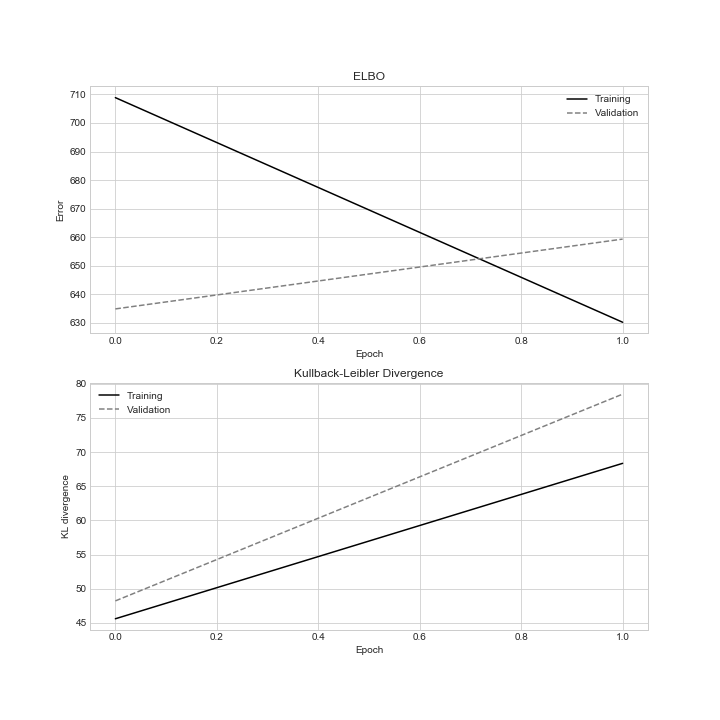

In [ ]:
# from torch.autograd import Variable
import time
import os
import math
tmp_img = "tmp_vae_out.png"

# 3 = ~12 minutes
num_epochs = 100

train_loss, valid_loss = [], []
train_kl, valid_kl = [], []

# Warmup weights
weight = 1 / (num_epochs - 1)

start = time.time()

print("Training epoch {}".format(0))
#epochs loop
for epoch in range(num_epochs):
    
    batch_loss, batch_kl = [], []
    net.train()

    for i_batch, sample_batched in enumerate(train_loader):
        #if i_batch == 10:
        #    break
        x = sample_batched['piano_rolls']

        x = x.type('torch.FloatTensor')
        
        #if i_batch%10==0:
        #    print("batch:",i_batch)

        x = Variable(x)

        # This is an alternative way of putting
        # a tensor on the GPU
        x = x.to(device)

        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']

        elbo, kl = loss_function(x_hat, x, mu, log_var, weight)

        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()

        batch_loss.append(elbo.item())
        batch_kl.append(kl.item())

    train_loss.append(np.mean(batch_loss))
    train_kl.append(np.mean(batch_kl))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()

        # Just load a single batch from the test loader
        x = next(iter(test_loader))
        x = Variable(x['piano_rolls'].type('torch.FloatTensor'))

        x = x.to(device)

        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']
        z = outputs["z"]

        elbo, kl = loss_function(x_hat, x, mu, log_var, 1.0)

        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x = x.to("cpu")
        x_hat = x_hat.to("cpu")
        z = z.detach().to("cpu").numpy()

        valid_loss.append(elbo.item())
        valid_kl.append(kl.item())

    if epoch == 0:
        continue
            
    # -- Plotting --
    f, axarr = plt.subplots(2, 1, figsize=(10, 10))
    
    
    # Loss
    ax = axarr[0]
    ax.set_title("ELBO")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')

    ax.plot(np.arange(epoch+1), train_loss, color="black")
    ax.plot(np.arange(epoch+1), valid_loss, color="gray", linestyle="--")
    ax.legend(['Training', 'Validation'])
    
    
    # KL / reconstruction
    ax = axarr[1]
    
    ax.set_title("Kullback-Leibler Divergence")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('KL divergence')


    ax.plot(np.arange(epoch+1), train_kl, color="black")
    ax.plot(np.arange(epoch+1), valid_kl, color="gray", linestyle="--")
    ax.legend(['Training', 'Validation'])
    
    print("Epoch: {}, {} seconds elapsed".format(epoch, time.time() - start))
    
    plt.savefig(tmp_img)
    plt.close(f)
    display(Image(filename=tmp_img))
    
    clear_output(wait=True)

    os.remove(tmp_img)

In [22]:
    sigma = torch.exp(log_var*2)
    n_mu = torch.Tensor([0])
    n_sigma = torch.Tensor([1])
    if cuda:
        n_mu = n_mu.cuda()
        n_sigma = n_sigma.cuda()

    p = Normal(n_mu, n_sigma)
    q = Normal(mu, sigma)

    #The method signature is P and Q, but might need to be reversed to calculate divergence of Q with respect to P
    kl_div = kl_divergence(q, p)




print(torch.mean(kl_div,dim=1)) # add a weight to the kl using warmup
    
    # notice minus sign as we want to maximise ELBO
 #   return -ELBO, kl_div.mean() # mean instead of sum



tensor([[3.4467e+00, 1.9657e+01, 3.9946e+00, 6.1268e+00, 2.5426e+01, 2.2764e+02,
         7.2790e+00, 1.8640e+01, 4.2117e+00, 1.8373e+33, 2.4963e+01, 7.0885e-01,
         2.9731e+01, 1.8100e+01, 2.1768e+01, 5.7642e+01, 7.9992e-02, 1.0539e+03,
         2.7513e+01, 1.1110e+00],
        [3.3021e+00, 1.9667e+01, 4.0010e+00, 6.1294e+00, 2.5433e+01, 2.2788e+02,
         7.2818e+00, 1.8650e+01, 4.2082e+00, 1.8575e+33, 2.4981e+01, 7.0948e-01,
         2.9751e+01, 1.8110e+01, 2.1779e+01, 5.7693e+01, 7.9818e-02, 1.0494e+03,
         2.7522e+01, 1.1136e+00],
        [3.3978e+00, 1.9690e+01, 4.0051e+00, 6.1458e+00, 2.5480e+01, 2.2861e+02,
         7.2954e+00, 1.8679e+01, 4.2184e+00, 1.8989e+33, 2.5007e+01, 7.0560e-01,
         2.9792e+01, 1.8140e+01, 2.1809e+01, 5.7849e+01, 7.9371e-02, 1.0488e+03,
         2.7563e+01, 1.1100e+00],
        [3.4466e+00, 1.9658e+01, 3.9945e+00, 6.1252e+00, 2.5424e+01, 2.2745e+02,
         7.2768e+00, 1.8639e+01, 4.2070e+00, 1.8156e+33, 2.4963e+01, 7.0838e-01,
       

In [ ]:
if not os.path.exists('midi'):
    os.makedirs('midi')

x_hat_np = x_hat.detach().numpy()
x_hat_np.shape
for i, seq in enumerate(x_hat_np):
    row_maxes = seq.max(axis=1).reshape(-1, 1)
    midi_out = np.where(seq == row_maxes, 1, 0)
    np.savetxt("midi/csv_midi_out_{}.csv".format(i), midi_out, delimiter=";")

    midi = builder.midi_from_piano_roll(midi_out)
    plt.figure(figsize=(10, 3))
    plt.title("Midi {}".format(i))
    
    builder.plot_midi(midi)
    plt.savefig("midi/img_midi_{}.png".format(i))

    midi.write('midi/{}.mid'.format(i))

    #synth, rate = builder.play_midi(midi)
    #Audio(synth, rate=rate)

In [ ]:
x_np = x.detach().numpy()
x_np.shape
for i, seq in enumerate(x_np):
    midi_out = seq

    # Only silence in this one :(
    if len(np.unique(midi_out)) == 1:
        continue
    
    midi = builder.midi_from_piano_roll(midi_out)
    plt.figure(figsize=(10, 3))
    plt.title("Orig Midi {}".format(i))

    builder.plot_midi(midi)
    plt.savefig("midi/img_midi_{}_orig.png".format(i))

    midi.write('midi/{}_orig.mid'.format(i))

    #synth, rate = builder.play_midi(midi)
    #Audio(synth, rate=rate)

In [ ]:
# Sample from latent space

batch_size = 1
sequence_length = 32
input_size = 512

z = torch.randn(sequence_length, batch_size, input_size)
print(z.shape)
# Define the conductor and note decoder
conductor = nn.LSTM(input_size, input_size)
decoder = nn.LSTM(2*input_size, input_size)

# Linear note to note type (classes)
classes = 4
linear = nn.Linear(input_size, classes)

conductor_hidden = (torch.randn(1, batch_size, input_size), torch.randn(1, batch_size, input_size))
notes = []

# For the first timestep the note is the embedding
note = torch.zeros(batch_size, batch_size, input_size)

# Go through each element in the latent sequence
for i in range(sequence_length):
    
    # Generate an embedding vector
    embedding, conductor_hidden = conductor(z[i].view(1, 1, -1), conductor_hidden)    

    # Reset the decoder state of each 16 bar sequence
    decoder_hidden = (torch.randn(1, batch_size, input_size), torch.randn(1, batch_size, input_size))

    for _ in range(16):
        # Concat embedding with previous note
        e = torch.cat([embedding, note], dim=-1)
        
        # Generate a single note
        note, decoder_hidden = decoder(e.view(1, 1, -1), decoder_hidden)
        
        # The note vector must be a probability of the different note types, e.g. (C#, F, E)
        notes.append(torch.softmax(linear(note.view(batch_size, -1)), dim=1))
        
notes = torch.cat(notes)